# Fine tune a model to a new dataset

### Import the necessary modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None


## Define Training Configurations (args)

In [2]:
dataset_name = "office5"
dataset_fn = office5_get_datasets
num_classes = 5
model_name = "office5"
dimensions = (3,128,128)
workers = 4
batch_size = 16
validation_split = 0.1
log_prefix = "office5-fine_tune_emb"
log_dir = "jupyter_logging"
data_path = "../Datasets/office5/"
deterministic = True
print_freq = 100
labels = ('back_pack', 'keyboard','laptop_computer','mug','pen')
lr = 0.001

## Define Helper Functions

In [3]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

## Set up the logger

In [4]:
msglogger = apputils.config_pylogger('logging.conf', log_prefix,
                                        log_dir)

# Log various details about the execution environment.  It is sometimes useful
# to refer to past experiment executions and this information may be useful.
apputils.log_execution_env_state(None, msglogger.logdir)
msglogger.debug("Distiller: %s", distiller.__version__)


pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+dataset_name)

tflogger.tblogger.writer.add_text('Command line', "args ---")

msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f',
                dataset_name,dataset_fn,num_classes,model_name,dimensions,batch_size,validation_split,lr)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/office5-fine_tune_emb___2022.06.29-115936/office5-fine_tune_emb___2022.06.29-115936.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7f7a95a7dc10>
num_classes=5
model_name=office5
dimensions=(3, 128, 128)
batch_size=16
validation_split=0.1
lr=0.001000



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and Load the Datasets

In [5]:
args = Args(act_mode_8bit=False)

In [6]:
train_set, test_set = office5_get_datasets((data_path, args), load_train=True, load_test=True)

../Datasets/office5/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}
../Datasets/office5/test
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


## Visualize a batch of training data

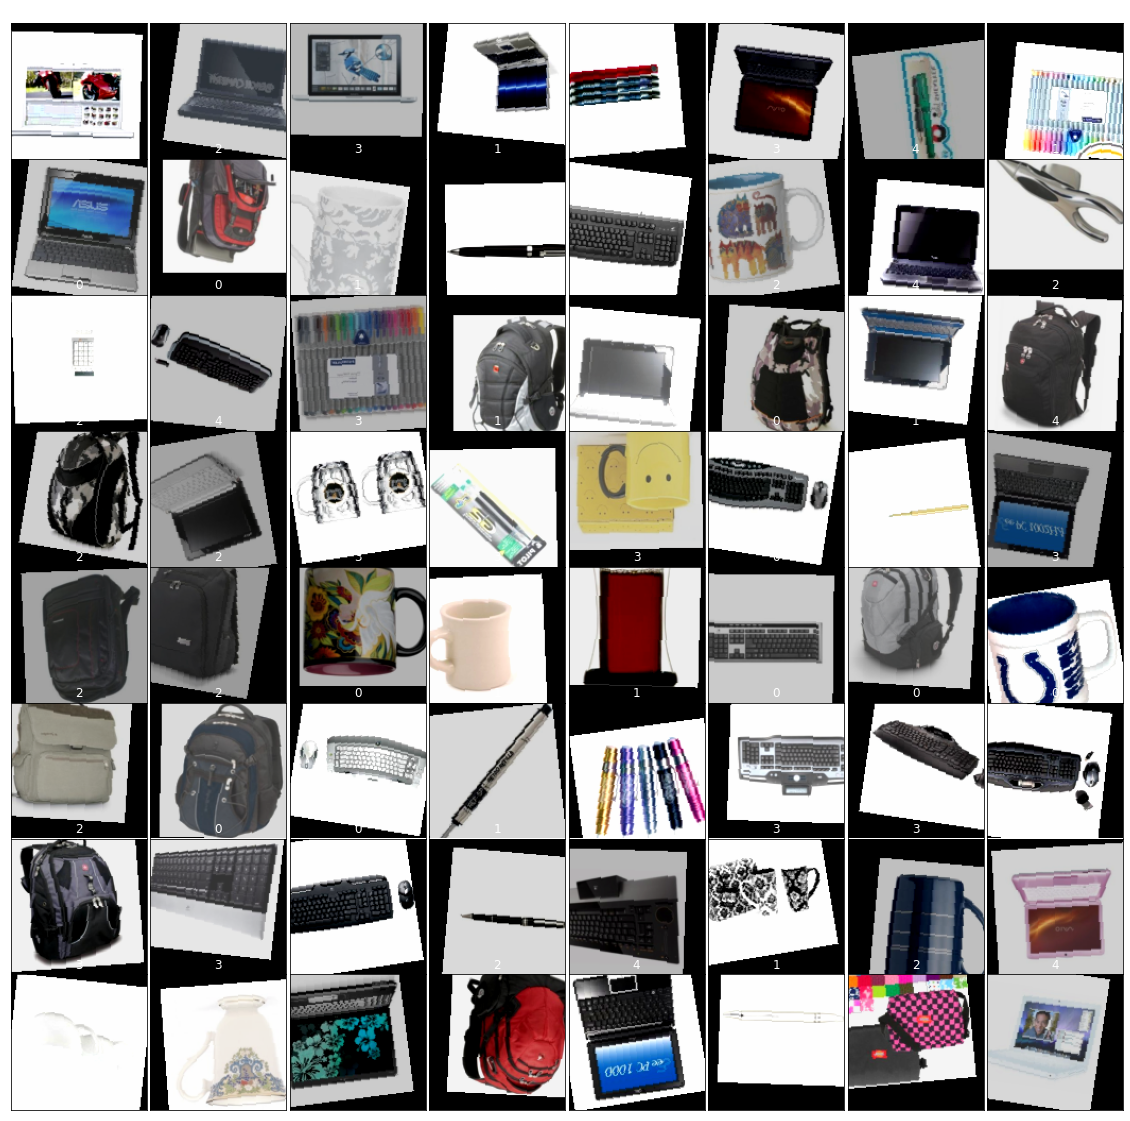

In [7]:
train_set.visualize_batch()

## Create the data loaders

In [8]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(
        dataset_fn, (data_path,args), batch_size,
        workers, validation_split, deterministic,1, 1, 1)
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d',
                   len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)
# train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
# test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=True)

Dataset sizes:
	training=388
	validation=43
	test=50
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.65, 1.35), contrast=(0.65, 1.35), saturation=(0.65, 1.35), hue=None)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.2, 0.2))
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}
../Datasets/office5/test
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


## Set up the device, cuda or cpu

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Set up the model for training

In [10]:
ai8x.set_device(device=85, simulate=False, round_avg=False)

model = mod.OfficeClassifier(device=device)
msglogger.info('model: %s',model)
model = model.to(device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+------------+
| Key                  | Type        | Value      |
|----------------------+-------------+------------|
| arch                 | str         | imagenet10 |
| compression_sched    | dict        |            |
| epoch                | int         | 1855       |
| extras               | dict        |            |
| optimizer_state_dict | dict        |            |
| optimizer_type       | type        | Adam       |
| state_dict           | OrderedDict |            |
+----------------------+-------------+------------+

=> Checkpoint['extras'] contents:
+--------------+--------+----------+
| Key          | Type   |    Value |
|--------------+--------+----------|
| best_epoch   | int    | 1855     |
| best_top1    | float  |   82.981 |
| current_top1 | float  |   82.981 |
+--------------+--------+----------+

L

Configuring device: MAX78000, simulate=False.


=> loaded 'state_dict' from checkpoint 'jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar'
/home/geffencooper/Model_Development/ai8x-training/models/minivgg.py:250: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)

model: OfficeClassifier(
  (feature_extractor): Imagenet10Classifier(
    (conv1): FusedConv2dReLU(
      (activate): ReLU(inplace=True)
      (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (calc_out_shift): OutputShift()
      (calc_weight_scale): WeightScale()
      (scale): Scaler()
      (calc_out_scale): OutputScale()
      (quantize_weight): Quantize()
      (quantize_bias): Quantize()
      (clamp_weight): Clamp()
      (clamp_bias): Clamp()
      (quantize): Quantize()
      (clamp): Clamp()
      (quantize_pool): Empty()
      (clamp_pool): Empty()
    )
    (conv2): FusedConv2dReLU(
      (activate): ReLU(inplace=

## Set up the training parameters

In [11]:
num_epochs = 50
msglogger.info('epochs: %d',num_epochs)
optimizer = optim.Adam(model.parameters(), lr=lr)
msglogger.info('Optimizer Type: %s', type(optimizer))
ms_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(ms_lr_scheduler.base_lrs)+" milestones: "+str(ms_lr_scheduler.milestones)+ " gamma: "+str(ms_lr_scheduler.gamma))
criterion = torch.nn.CrossEntropyLoss().to(device)

qat_policy = {'start_epoch':10,
              'weight_bits':8}
msglogger.info('qat policy: %s',qat_policy)
compression_scheduler = distiller.CompressionScheduler(model)

epochs: 50
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5
qat policy: {'start_epoch': 10, 'weight_bits': 8}


## Validation Function

In [12]:
def validate(data_loader, model, criterion, loggers, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # keep track of incorrect predictions
    wrong_samples = None
    wrong_preds = None
    actual_preds = None
    img_names = None

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(num_classes, 5)))

    # validation set info
    batch_time = tnt.AverageValueMeter()
    total_samples = len(data_loader.sampler)
    batch_size = data_loader.batch_size
    confusion = tnt.ConfusionMeter(num_classes)
    total_steps = (total_samples + batch_size - 1) // batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, batch_size)

    # Switch to evaluation mode
    model.eval()

    end = time.time()
    class_probs = []
    class_preds = []

    # iterate over the batches in the validation set
    for validation_step, (inputs, target, names) in enumerate(data_loader):
        with torch.no_grad():
            inputs, target = inputs.to(device), target.to(device)
            # compute output from model
            output = model(inputs)

            # correct output for accurate loss calculation
            if args.act_mode_8bit:
                output /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        output /= 256.

            # # get the idxs of the max output
            # pred = output.argmax(dim=1, keepdim=True)
            
            # wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0] # get wrong predictions
            
            # if validation_step == 0:
            #     wrong_samples = inputs[wrong_idx]
            #     wrong_preds = pred[wrong_idx]
            #     actual_preds = target.view_as(pred)[wrong_idx]
            #     img_names = [names[i.item()] for i in wrong_idx] #names[wrong_idx]
            # else:
            #     wrong_samples = torch.cat((wrong_samples,inputs[wrong_idx]),0)
            #     wrong_preds = torch.cat((wrong_preds,pred[wrong_idx]),0)
            #     actual_preds = torch.cat((actual_preds,target.view_as(pred)[wrong_idx]),0)
            #     img_names.extend([names[i.item()] for i in wrong_idx])

            # compute loss
            loss = criterion(output, target)

            # measure accuracy and record loss
            losses['objective_loss'].add(loss.item())
            if len(output.data.shape) <= 2:
                classerr.add(output.data, target)
            else:
                classerr.add(output.data.permute(0, 2, 3, 1).flatten(start_dim=0, end_dim=2),
                                target.flatten())
            
            confusion.add(output.data, target)

            # measure elapsed time
            batch_time.add(time.time() - end)
            end = time.time()

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                _, class_preds_batch = torch.max(output, 1)
                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                )
                if num_classes > 5:
                    stats[1]['Top5'] = classerr.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, print_freq, loggers)


                # if tflogger is not None:
                #     test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
                #     test_preds = torch.cat(class_preds)
                #     for i in range(num_classes):
                #         tb_preds = test_preds == i
                #         tb_probs = test_probs[:, i]
                #         tflogger.tblogger.writer.add_pr_curve(str(args.labels[i]), tb_preds,
                #                                             tb_probs, global_step=epoch)

                # if steps_completed == total_steps and tflogger is not None:
                #     def select_n_random(data, labels, features, n=100):
                #         """Selects n random datapoints, their corresponding labels and features"""
                #         assert len(data) == len(labels) == len(features)

                #         perm = torch.randperm(len(data))
                #         return data[perm][:n], labels[perm][:n], features[perm][:n]

                #     # Select up to 100 random images and their target indices
                #     images, labels, features = select_n_random(inputs, target, output,
                #                                                n=min(100, len(inputs)))

                #     # Get the class labels for each image
                #     class_labels = [args.labels[lab] for lab in labels]

                #     tflogger.tblogger.writer.add_embedding(
                #         features,
                #         metadata=class_labels,
                #         label_img=args.visualize_fn(images, args),
                #         global_step=epoch,
                #         tag='verification/embedding'
                #     )

    if num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n',
                        classerr.value()[0], classerr.value()[1],
                        losses['objective_loss'].mean)
    else:
        msglogger.info('==> Top1: %.3f    Loss: %.3f\n',
                        classerr.value()[0], losses['objective_loss'].mean)

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
    # if epoch > 0:
    #     data_loader.dataset.viz_mispredict(wrong_samples,wrong_preds,actual_preds,img_names)
    return classerr.value(1), classerr.value(min(num_classes, 5)), losses['objective_loss'].mean

## Run the training loop

In [13]:
# store model history across epochs
perf_scores_history = []
model = model.to(device)

name = model_name

# start the clock
tic = datetime.now()

# training loop
for epoch in range(0, num_epochs):
    # check if need to switch to QAT
    if epoch > 0 and epoch == qat_policy['start_epoch']:
        print('QAT is starting!')
        # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
        ai8x.fuse_bn_layers(model)

        # Switch model from unquantized to quantized for QAT
        ai8x.initiate_qat(model, qat_policy)

        # Model is re-transferred to GPU in case parameters were added
        model.to(device)

        # Empty the performance scores list for QAT operation
        perf_scores_history = []
        name = f'{model_name}_qat'

    # store loss and training stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(num_classes, 5)))
    batch_time = tnt.AverageValueMeter()
    data_time = tnt.AverageValueMeter()

    # logging stats
    total_samples = len(train_loader.sampler)
    batch_size = train_loader.batch_size
    steps_per_epoch = (total_samples + batch_size - 1) // batch_size
    msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, batch_size)

    # Switch to train mode
    model.train()
    acc_stats = []
    end = time.time()

    # iterate over all batches in the dataset
    for train_step, (inputs, target, names) in enumerate(train_loader):
        # Measure data loading time
        data_time.add(time.time() - end)
        inputs, target = inputs.to(device), target.to(device)

        # forward pass and loss calculation
        output = model(inputs)
        loss = criterion(output, target)

        # on the last batch store the stats for the epoch
        if train_step >= len(train_loader)-2:
            if len(output.data.shape) <= 2:
                classerr.add(output.data, target)
            else:
                classerr.add(output.data.permute(0, 2, 3, 1).flatten(start_dim=0, end_dim=2),
                                target.flatten())
            acc_stats.append([classerr.value(1), classerr.value(min(num_classes, 5))])

        # add the loss for each batch
        losses["objective_loss"].add(loss.item())

        # reset the optimizer
        optimizer.zero_grad()

        # backwards pass and parameter update
        loss.backward()
        optimizer.step()

        # track batch stats
        batch_time.add(time.time() - end)
        steps_completed = (train_step+1)

        # log stats every 10 batches
        if steps_completed % print_freq == 0 or steps_completed == steps_per_epoch:
            # Log some statistics
            errs = OrderedDict()
            if classerr.n != 0:
                errs['Top1'] = classerr.value(1)
                if num_classes > 5:
                    errs['Top5'] = classerr.value(5)
            else:
                errs['Top1'] = None
                errs['Top5'] = None

            stats_dict = OrderedDict()
            for loss_name, meter in losses.items():
                stats_dict[loss_name] = meter.mean
            stats_dict.update(errs)
            
            stats_dict['LR'] = optimizer.param_groups[0]['lr']
            stats_dict['Time'] = batch_time.mean
            stats = ('Performance/Training/', stats_dict)
            params = None
            distiller.log_training_progress(stats,
                                            params,
                                            epoch, steps_completed,
                                            steps_per_epoch, print_freq,
                                            all_loggers)
        end = time.time()



    # after a training epoch, do validation
    msglogger.info('--- validate (epoch=%d)-----------', epoch)
    top1, top5, vloss = validate(val_loader, model, criterion, [pylogger], epoch, tflogger)

    # store validation stats
    stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
    if num_classes > 5:
        stats[1]['Top5'] = top5

    distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                            log_freq=1, loggers=all_tbloggers)

    perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                            'epoch': epoch}))
    # Keep perf_scores_history sorted from best to worst
    # Sort by top1 as main sort key, then sort by top5 and epoch
    perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
    for score in perf_scores_history[:1]:
        if num_classes > 5:
            msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                            score.top1, score.top5,score.epoch)
        else:
            msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                            score.top1, score.epoch)

    # Save the checkpoint
    is_best = epoch == perf_scores_history[0].epoch
    checkpoint_extras = {'current_top1': top1,
                        'best_top1': perf_scores_history[0].top1,
                        'best_epoch': perf_scores_history[0].epoch}

    apputils.save_checkpoint(epoch, model_name, model, optimizer=optimizer,
                                scheduler=compression_scheduler, extras=checkpoint_extras,
                                is_best=is_best, name=name,
                                dir=msglogger.logdir)

    ms_lr_scheduler.step()

# Finally run results on the test set
top1, top5, losses = validate(test_loader, model, criterion, [pylogger],epoch,None)
msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)

msglogger.info('Training time: %s', datetime.now() - tic)

Training epoch: 388 samples (16 per mini-batch)
Epoch: [0][   25/   25]    objective_loss 1.507334    Top1 55.000000    LR 0.001000    Time 0.037104    
--- validate (epoch=0)-----------
43 samples (16 per mini-batch)
Epoch: [0][    3/    3]    Loss 1.269788    Top1 65.116279    
==> Top1: 65.116    Loss: 1.270

==> Confusion:
[[3 2 0 0 2]
 [0 9 1 0 1]
 [0 0 7 1 1]
 [0 3 1 3 0]
 [0 2 1 0 6]]

==> Best [Top1: 65.116 on epoch: 0]
Saving checkpoint to: jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_checkpoint.pth.tar
Training epoch: 388 samples (16 per mini-batch)
Epoch: [1][   25/   25]    objective_loss 1.160352    Top1 75.000000    LR 0.001000    Time 0.027432    
--- validate (epoch=1)-----------
43 samples (16 per mini-batch)
Epoch: [1][    3/    3]    Loss 0.975176    Top1 69.767442    
==> Top1: 69.767    Loss: 0.975

==> Confusion:
[[4 0 0 1 2]
 [0 8 1 1 1]
 [0 0 5 3 1]
 [0 0 1 6 0]
 [0 1 0 1 7]]

==> Best [Top1: 69.767 on epoch: 1]
Saving checkpoint to: jupyter_log

QAT is starting!


Epoch: [10][   25/   25]    objective_loss 0.429536    Top1 90.000000    LR 0.000500    Time 0.028679    
--- validate (epoch=10)-----------
43 samples (16 per mini-batch)
Epoch: [10][    3/    3]    Loss 0.454793    Top1 81.395349    
==> Top1: 81.395    Loss: 0.455

==> Confusion:
[[4 0 0 2 1]
 [0 9 1 1 0]
 [0 0 8 0 1]
 [0 0 0 7 0]
 [1 1 0 0 7]]

==> Best [Top1: 81.395 on epoch: 10]
Saving checkpoint to: jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_checkpoint.pth.tar
Training epoch: 388 samples (16 per mini-batch)
Epoch: [11][   25/   25]    objective_loss 0.472171    Top1 85.000000    LR 0.000500    Time 0.028776    
--- validate (epoch=11)-----------
43 samples (16 per mini-batch)
Epoch: [11][    3/    3]    Loss 0.452928    Top1 88.372093    
==> Top1: 88.372    Loss: 0.453

==> Confusion:
[[ 7  0  0  0  0]
 [ 0 10  0  1  0]
 [ 0  0  8  1  0]
 [ 0  0  0  7  0]
 [ 1  1  1  0  6]]

==> Best [Top1: 88.372 on epoch: 11]
Saving checkpoint to: jupyter_logging/office

## Visualize Embeddings

### 1: Visualize office clusters from dataset and from camera  
* for the dataset images, set the test_batch_path to ../Datasets/office5/
* for the camera images, set the test_batch_path to ../Datasets/office5_camera/

In [28]:
# grab the test batch
test_batch_path = "../Datasets/office5_camera/"
#args = Args(act_mode_8bit=True)
_, test_set = cats_and_dogs_get_datasets((test_batch_path, args), load_train=False, load_test=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

# load the trained model
#load_model_path = "jupyter_logging/batch32_40ep_128fc___2022.06.23-155205/catdognet_qat_best.pth.tar"
load_model_path = "jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best.pth.tar"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ai8x.set_device(device=85, simulate=False, round_avg=False)
model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

# get a batch of data
(batch_imgs, batch_labels, names) = next(iter(test_loader))
batch_imgs,batch_labels = batch_imgs.to(device), batch_labels.to(device)

# register forward hook to get embedding output
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# get the activations
model.eval()
model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
preds = model(batch_imgs)
embds = activation['fc1']

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    if label.item() == 0:
        batch_label_strings.append("keyboard")
    elif label.item() == 1:
        batch_label_strings.append("pen")
    elif label.item() == 2:
        batch_label_strings.append("backpack")
    elif label.item() == 3:
        batch_label_strings.append("mug")
    elif label.item() == 4:
        batch_label_strings.append("laptop")

# log to tensorboard
tflogger.tblogger.writer.add_embedding(
        embds.to('cpu'),
        #metadata=batch_names,
        metadata=batch_label_strings,
        label_img=batch_imgs.to('cpu'),
        global_step=0
    )

=> loading checkpoint jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+------------+
| Key                  | Type        | Value      |
|----------------------+-------------+------------|
| arch                 | str         | imagenet10 |
| compression_sched    | dict        |            |
| epoch                | int         | 1855       |
| extras               | dict        |            |
| optimizer_state_dict | dict        |            |
| optimizer_type       | type        | Adam       |
| state_dict           | OrderedDict |            |
+----------------------+-------------+------------+

=> Checkpoint['extras'] contents:
+--------------+--------+----------+
| Key          | Type   |    Value |
|--------------+--------+----------|
| best_epoch   | int    | 1855     |
| best_top1    | float  |   82.981 |
| current_top1 | float  |   82.981 |
+--------------+--------+----------+

L

../Datasets/office5_camera/test
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}
Configuring device: MAX78000, simulate=False.


In [29]:
np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs)

0.5

## Visualize difference in domains

In [31]:
# grab the test batch
test_batch_path = "../Datasets/office5_both/"
#args = Args(act_mode_8bit=True)
_, test_set = cats_and_dogs_get_datasets((test_batch_path, args), load_train=False, load_test=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

# load the trained model
#load_model_path = "jupyter_logging/batch32_40ep_128fc___2022.06.23-155205/catdognet_qat_best.pth.tar"
load_model_path = "jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best.pth.tar"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ai8x.set_device(device=85, simulate=False, round_avg=False)
model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

# get a batch of data
(batch_imgs, batch_labels, names) = next(iter(test_loader))
batch_imgs,batch_labels = batch_imgs.to(device), batch_labels.to(device)

# register forward hook to get embedding output
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# get the activations
model.eval()
model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
preds = model(batch_imgs)
embds = activation['fc1']

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    if label.item() == 0:
        batch_label_strings.append("camera")
    elif label.item() == 1:
        batch_label_strings.append("dataset")
    elif label.item() == 2:
        batch_label_strings.append("camera")
    elif label.item() == 3:
        batch_label_strings.append("dataset")
    elif label.item() == 4:
        batch_label_strings.append("dataset")
    elif label.item() == 5:
        batch_label_strings.append("dataset")
    elif label.item() == 6:
        batch_label_strings.append("camera")
    elif label.item() == 7:
        batch_label_strings.append("camera")
    elif label.item() == 8:
        batch_label_strings.append("dataset")
    elif label.item() == 9:
        batch_label_strings.append("camera")

# log to tensorboard
tflogger.tblogger.writer.add_embedding(
        embds.to('cpu'),
        #metadata=batch_names,
        metadata=batch_label_strings,
        label_img=batch_imgs.to('cpu'),
        global_step=0
    )

=> loading checkpoint jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+------------+
| Key                  | Type        | Value      |
|----------------------+-------------+------------|
| arch                 | str         | imagenet10 |
| compression_sched    | dict        |            |
| epoch                | int         | 1855       |
| extras               | dict        |            |
| optimizer_state_dict | dict        |            |
| optimizer_type       | type        | Adam       |
| state_dict           | OrderedDict |            |
+----------------------+-------------+------------+

=> Checkpoint['extras'] contents:
+--------------+--------+----------+
| Key          | Type   |    Value |
|--------------+--------+----------|
| best_epoch   | int    | 1855     |
| best_top1    | float  |   82.981 |
| current_top1 | float  |   82.981 |
+--------------+--------+----------+

L

../Datasets/office5_both/test
{'pen_camera': 0, 'keyboard_dataset': 1, 'backpack_camera': 2, 'laptop_dataset': 3, 'mug_dataset': 4, 'pen_dataset': 5, 'laptop_camera': 6, 'keyboard_camera': 7, 'backpack_dataset': 8, 'mug_camera': 9}
Configuring device: MAX78000, simulate=False.


In [11]:
# grab the test batch
test_batch_path = "../Datasets/office5_both/"
#args = Args(act_mode_8bit=True)
_, test_set = cats_and_dogs_get_datasets((test_batch_path, args), load_train=False, load_test=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

# load the trained model
#load_model_path = "jupyter_logging/batch32_40ep_128fc___2022.06.23-155205/catdognet_qat_best.pth.tar"
load_model_path = "jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best.pth.tar"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ai8x.set_device(device=85, simulate=False, round_avg=False)
model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

# get a batch of data
(batch_imgs, batch_labels, names) = next(iter(test_loader))
batch_imgs,batch_labels = batch_imgs.to(device), batch_labels.to(device)

# register forward hook to get embedding output
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# get the activations
model.eval()
model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
preds = model(batch_imgs)
embds = activation['fc1']

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    if label.item() == 0:
        batch_label_strings.append("pen_camera")
    elif label.item() == 1:
        batch_label_strings.append("keyboard_dataset")
    elif label.item() == 2:
        batch_label_strings.append("backpack_camera")
    elif label.item() == 3:
        batch_label_strings.append("laptop_dataset")
    elif label.item() == 4:
        batch_label_strings.append("mug_dataset")
    elif label.item() == 5:
        batch_label_strings.append("pen_dataset")
    elif label.item() == 6:
        batch_label_strings.append("laptop_camera")
    elif label.item() == 7:
        batch_label_strings.append("keyboard_camera")
    elif label.item() == 8:
        batch_label_strings.append("backpack_dataset")
    elif label.item() == 9:
        batch_label_strings.append("mug_camera")

# log to tensorboard
tflogger.tblogger.writer.add_embedding(
        embds.to('cpu'),
        #metadata=batch_names,
        metadata=batch_label_strings,
        label_img=batch_imgs.to('cpu'),
        global_step=0
    )


=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

../Datasets/test_batch4/test
{'cat_dataset': 0, 'dog_camera': 1, 'dog_dataset': 2, 'cat_camera': 3}
Configuring device: MAX78000, simulate=False.


## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [1]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best.pth.tar jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best.pth.tar to jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best-q.pth.tar

Model keys (state_dict):
feature_extractor.conv1.output_shift, feature_extractor.conv1.weight_bits, feature_extractor.conv1.bias_bits, feature_extractor.conv1.quantize_activation, feature_extractor.conv1.adjust_output_shift, feature_extractor.conv1.shift_quantile, feature_extractor.conv1.op.weight, feature_extractor.conv2.output_shift, feature_extractor.conv2.weight_bits, feature_extractor.conv2.bias_bits, feature_extractor.conv2.quantize_activation, feature_extractor.conv2.adjust_output_shift, feature_extractor.conv2.shift_quantile, feature_extractor.conv2.op.weight, feature_extractor.conv3.output_shift, feature_extractor.conv3.weight_bits, feature_extractor.conv3.bias_bits, feature_extractor.conv3.quantize_activation, feature_extractor.conv3.adjust_output_shift, featu

## Evaluate Quantized Model

Change virtual environment back to ai8x-training and rerun the first cell with the imports

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = 'jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best-q.pth.tar'
# Change this path to match file system layout
data_path = "../Datasets/office5/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.OfficeClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


In [6]:
args = Args(act_mode_8bit=True)

_, test_set = office5_get_datasets((data_path, args), load_train=True, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

../Datasets/office5/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}
../Datasets/office5/test
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


In [6]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label, name in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 92.00%


In [9]:
for image, label, name in test_dataloader:
    break

im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
img = image[0].detach().cpu().permute(1, 2, 0).numpy()

np.save('sample_office5.npy', im_sample)

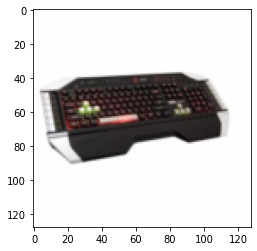

In [14]:
plt.imshow((img+128)/256)

## Model Synthesis

In [1]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix office5 --checkpoint-file ../ai8x-training/jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best-q.pth.tar --config-file networks/classifier.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

Creating network...  ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━  38%